
# Fire Detection Using ResNet with Synthetic Unity-generated Images

## Overview
This notebook implements a fire detection system using a ResNet-50 model with PyTorch. The system is designed to classify images as either containing fire or not containing fire. It includes data preprocessing, model training, evaluation, and visualization components. 

## Key Features:
- **Transfer Learning**: Uses pre-trained ResNet-50 for better performance
- **Data Augmentation**: Improves model generalization
- **Class Imbalance Handling**: Weighted sampling for balanced training
- **Early Stopping**: Prevents overfitting
- **Comprehensive Evaluation**: Includes confusion matrix and classification reports

## Datasets Used:
- Sen2Fire Dataset: A real-world satellite image dataset for fire detection, available at [Zenodo](https://zenodo.org/records/10881058).
- **Data Augmentation**: Synthetic Unity-generated Dataset: A custom dataset created using Unity to simulate various fire and non-fire scenarios. This dataset was generated by *Dastan Nurbekuly* to augment training data and enhance model robustness under different conditions.

## 1. Import Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import glob

## 2. Custom Dataset Class

This custom ```Dataset``` class is a standard PyTorch utility that loads and preprocesses images and their corresponding labels. It takes a list of image file paths and labels, and a ```transform``` object to apply data augmentation.

In [2]:
class FireDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load image
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

## 3. Dataset Loading Function

The `load_dataset` function loads images from a structured folder hierarchy and supports Unity-generated synthetic images.

In [3]:
def load_dataset(base_path, unity_images_path=None, max_fire_per_scene=None, 
                target_fire_ratio=None, use_all_unity=True):
    """
    Load dataset from your folder structure with smart sampling
    base_path: path to folder containing scene folders
    unity_images_path: path to Unity-generated fire images
    max_fire_per_scene: maximum fire images per scene (None = use all)
    target_fire_ratio: target ratio of fire to no_fire (e.g., 0.5 for 1:2 ratio)
    use_all_unity: whether to use all Unity images or sample them
    """
    image_paths = []
    labels = []
    
    # First pass: count all images to understand dataset
    total_fire = 0
    total_no_fire = 0
    scene_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
    
    # Count existing images
    for scene_folder in scene_folders:
        scene_path = os.path.join(base_path, scene_folder)
        
        fire_path = os.path.join(scene_path, 'fire')
        if os.path.exists(fire_path):
            fire_count = len(glob.glob(os.path.join(fire_path, '*.jpg')) + 
                           glob.glob(os.path.join(fire_path, '*.png')) + 
                           glob.glob(os.path.join(fire_path, '*.jpeg')))
            total_fire += fire_count
        
        no_fire_path = os.path.join(scene_path, 'no_fire')
        if os.path.exists(no_fire_path):
            no_fire_count = len(glob.glob(os.path.join(no_fire_path, '*.jpg')) + 
                              glob.glob(os.path.join(no_fire_path, '*.png')) + 
                              glob.glob(os.path.join(no_fire_path, '*.jpeg')))
            total_no_fire += no_fire_count
    
    # Count Unity images
    unity_count = 0
    if unity_images_path and os.path.exists(unity_images_path):
        unity_count = len(glob.glob(os.path.join(unity_images_path, '*.jpg')) + 
                         glob.glob(os.path.join(unity_images_path, '*.png')) + 
                         glob.glob(os.path.join(unity_images_path, '*.jpeg')))
    
    print(f"Dataset overview:")
    print(f"Fire images from scenes: {total_fire}")
    print(f"No-fire images from scenes: {total_no_fire}")
    print(f"Unity fire images: {unity_count}")
    print(f"Initial ratio (fire/no_fire): {(total_fire + unity_count)/total_no_fire:.3f}")
    
    # Calculate sampling strategy
    if target_fire_ratio:
        target_fire_count = int(total_no_fire * target_fire_ratio)
        available_fire = total_fire + unity_count
        
        if available_fire > target_fire_count:
            print(f"Sampling {target_fire_count} fire images from {available_fire} available")
            fire_per_scene = min(max_fire_per_scene or float('inf'), 
                                target_fire_count // len(scene_folders))
            use_unity_count = max(0, target_fire_count - (fire_per_scene * len(scene_folders)))
        else:
            print(f"Using all {available_fire} fire images (less than target {target_fire_count})")
            fire_per_scene = max_fire_per_scene
            use_unity_count = unity_count
    else:
        fire_per_scene = max_fire_per_scene
        use_unity_count = unity_count if use_all_unity else min(50, unity_count)
    
    # Load from scene folders with sampling
    for scene_folder in scene_folders:
        scene_path = os.path.join(base_path, scene_folder)
        
        # Load fire images
        fire_path = os.path.join(scene_path, 'fire')
        if os.path.exists(fire_path):
            fire_images = glob.glob(os.path.join(fire_path, '*.jpg')) + \
                         glob.glob(os.path.join(fire_path, '*.png')) + \
                         glob.glob(os.path.join(fire_path, '*.jpeg'))
            
            # Sample fire images if needed
            if fire_per_scene and len(fire_images) > fire_per_scene:
                fire_images = np.random.choice(fire_images, fire_per_scene, replace=False).tolist()
            
            image_paths.extend(fire_images)
            labels.extend([1] * len(fire_images))
        
        # Load no_fire images
        no_fire_path = os.path.join(scene_path, 'no_fire')
        if os.path.exists(no_fire_path):
            no_fire_images = glob.glob(os.path.join(no_fire_path, '*.jpg')) + \
                            glob.glob(os.path.join(no_fire_path, '*.png')) + \
                            glob.glob(os.path.join(no_fire_path, '*.jpeg'))
            image_paths.extend(no_fire_images)
            labels.extend([0] * len(no_fire_images))
    
    # Add Unity-generated fire images
    if unity_images_path and os.path.exists(unity_images_path):
        unity_images = glob.glob(os.path.join(unity_images_path, '*.jpg')) + \
                      glob.glob(os.path.join(unity_images_path, '*.png')) + \
                      glob.glob(os.path.join(unity_images_path, '*.jpeg'))
        
        # Sample Unity images if needed
        if use_unity_count and len(unity_images) > use_unity_count:
            unity_images = np.random.choice(unity_images, use_unity_count, replace=False).tolist()
        
        image_paths.extend(unity_images)
        labels.extend([1] * len(unity_images))
    
    # Final statistics
    final_fire = sum(labels)
    final_no_fire = len(labels) - final_fire
    print(f"\nFinal dataset:")
    print(f"Fire images: {final_fire}")
    print(f"No-fire images: {final_no_fire}")
    print(f"Final ratio (fire/no_fire): {final_fire/final_no_fire:.3f}")
    
    return image_paths, labels

## 4. Helper Functions for Data Handling and Model Creation

These functions perform key tasks for the training pipeline.

- ```create_weighted_sampler```: Generates a WeightedRandomSampler to address class imbalance in the training data by giving more weight to underrepresented classes.

- ```get_transforms```: Defines the data augmentation pipeline for training and validation images.

- ```create_resnet_model```: Loads a pre-trained ResNet-50 model and modifies its final layer for binary classification.

In [4]:
def create_weighted_sampler(labels):
    """Create weighted sampler to handle class imbalance"""
    class_counts = Counter(labels)
    total_samples = len(labels)
    
    # Calculate weights for each class
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    
    # Create sample weights
    sample_weights = [class_weights[label] for label in labels]
    
    return WeightedRandomSampler(sample_weights, len(sample_weights))

def get_transforms():
    """Define data transformations"""
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

def create_resnet_model(num_classes=2, pretrained=True):
    """Create ResNet model for binary classification"""
    model = models.resnet50(pretrained=pretrained)
    
    # Modify the final layer for binary classification
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    
    return model

## 5. Model Training Function

This function contains the main training loop. It trains the model on the training set, evaluates it on the validation set at the end of each epoch, and implements two important regularization techniques:

- **Learning Rate Scheduling**: The ```ReduceLROnPlateau``` scheduler dynamically reduces the learning rate when the validation loss stops improving.

- **Early Stopping**: Training is halted if the validation accuracy does not improve for a certain number of epochs (```early_stopping_patience```), preventing overfitting. The best performing model is saved as ```best_fire_model.pth```.


In [5]:
def train_model(model, train_loader, val_loader, num_epochs=50, device='cuda'):
    """Training function with early stopping and learning rate scheduling"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Lower learning rate
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0
    patience_counter = 0
    early_stopping_patience = 15  # Give it more time to improve
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Calculate metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 50)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_fire_model_with_unity.pth')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
    
    return train_losses, val_losses, train_accuracies, val_accuracies

## 6. Evaluation and Plotting Functions

These functions are used to visualize the training process and evaluate the final model's performance on the test set.

- ```evaluate_model```: Generates a classification report and a confusion matrix to show how well the model performs on unseen data.

- ```plot_training_history```: Creates a plot of training and validation loss and accuracy over time, helping to diagnose overfitting or underfitting.

In [6]:
def evaluate_model(model, test_loader, device='cuda'):
    """Evaluate model and generate classification report"""
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Generate classification report
    class_names = ['No Fire', 'Fire']
    report = classification_report(all_labels, all_predictions, target_names=class_names)
    print("Classification Report:")
    print(report)
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return all_predictions, all_labels

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

## 7. Main Function and Execution

This function ties everything together. It sets the configuration, loads the dataset using the advanced ```load_dataset function```, splits the data, creates data loaders, and then calls the ```train_model``` and ```evaluate_model``` functions. This is where you would run the entire training and evaluation pipeline.

Using device: cuda
Loading dataset...
Dataset overview:
Fire images from scenes: 349
No-fire images from scenes: 2117
Unity fire images: 50
Initial ratio (fire/no_fire): 0.188
Using all 399 fire images (less than target 846)

Final dataset:
Fire images: 382
No-fire images: 2117
Final ratio (fire/no_fire): 0.180
Dataset statistics:
Total images: 2499
Fire images: 382
No fire images: 2117
Class ratio (fire/no_fire): 0.18


c:\Users\Dastan\anaconda3\envs\patching\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Dastan\anaconda3\envs\patching\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training...
Epoch [1/50]
Train Loss: 0.5554, Train Acc: 71.11%
Val Loss: 0.8147, Val Acc: 66.50%
LR: 0.000100
--------------------------------------------------
Epoch [2/50]
Train Loss: 0.4454, Train Acc: 79.30%
Val Loss: 0.7843, Val Acc: 70.25%
LR: 0.000100
--------------------------------------------------
Epoch [3/50]
Train Loss: 0.4070, Train Acc: 81.99%
Val Loss: 0.3916, Val Acc: 84.25%
LR: 0.000100
--------------------------------------------------
Epoch [4/50]
Train Loss: 0.3654, Train Acc: 83.43%
Val Loss: 0.8881, Val Acc: 66.25%
LR: 0.000100
--------------------------------------------------
Epoch [5/50]
Train Loss: 0.3472, Train Acc: 85.30%
Val Loss: 0.4607, Val Acc: 83.25%
LR: 0.000100
--------------------------------------------------
Epoch [6/50]
Train Loss: 0.3070, Train Acc: 86.87%
Val Loss: 0.5294, Val Acc: 82.75%
LR: 0.000100
--------------------------------------------------
Epoch [7/50]
Train Loss: 0.2771, Train Acc: 88.43%
Val Loss: 0.5751, Val Acc: 77.00%


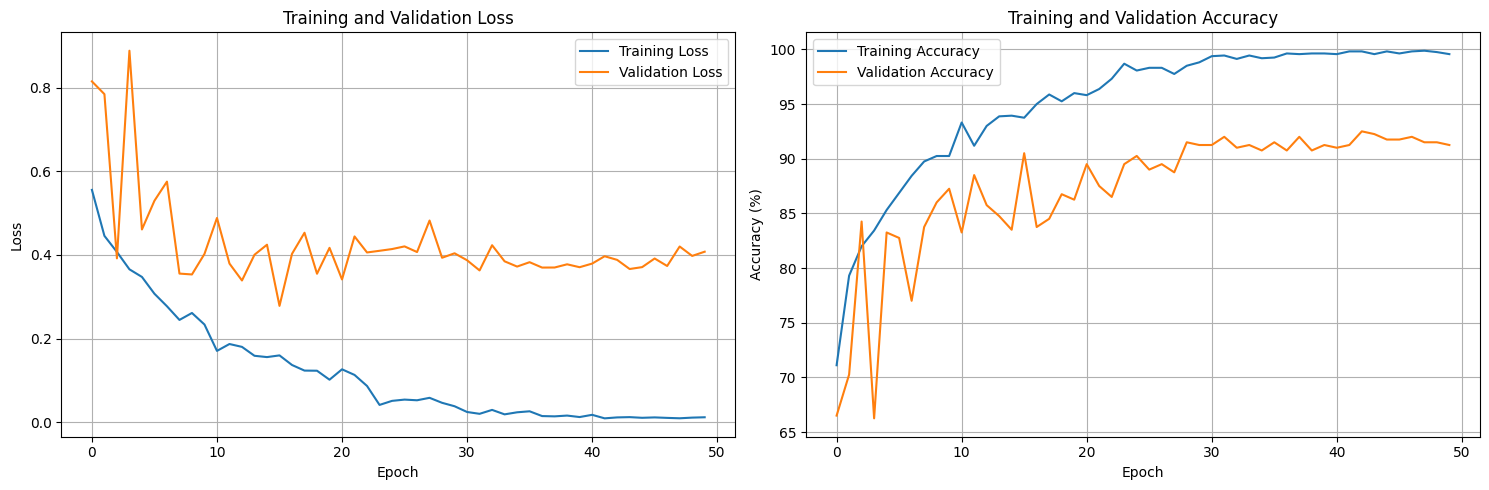

C:\Users\Dastan\AppData\Local\Temp\ipykernel_20968\2523535248.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_fire_model_with_uni


Evaluating on test set...
Classification Report:
              precision    recall  f1-score   support

     No Fire       0.92      0.97      0.94       424
        Fire       0.78      0.50      0.61        76

    accuracy                           0.90       500
   macro avg       0.85      0.74      0.78       500
weighted avg       0.89      0.90      0.89       500



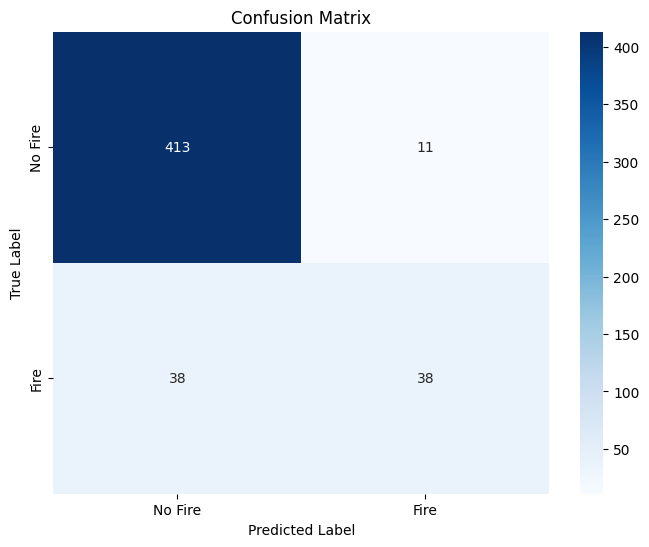

Training completed!
Best model saved as 'best_fire_model_with_unity.pth'


In [7]:
def main():
    # Configuration
    BASE_PATH = "./sen2fire"  # Update this path
    UNITY_IMAGES_PATH = "./unity_generated"  # Update this path
    BATCH_SIZE = 32
    NUM_EPOCHS = 50
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print(f"Using device: {DEVICE}")
    
    # Load dataset
    print("Loading dataset...")
    image_paths, labels = load_dataset(
        BASE_PATH, 
        UNITY_IMAGES_PATH,
        max_fire_per_scene=100,  # Max fire images per scene
        target_fire_ratio=0.4,   # Target 40% fire images (1:1.5 ratio)
        use_all_unity=True       # Use all Unity images
    )
    
    # Print dataset statistics
    class_counts = Counter(labels)
    print(f"Dataset statistics:")
    print(f"Total images: {len(image_paths)}")
    print(f"Fire images: {class_counts[1]}")
    print(f"No fire images: {class_counts[0]}")
    print(f"Class ratio (fire/no_fire): {class_counts[1]/class_counts[0]:.2f}")
    
    # Split dataset
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        image_paths, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_paths, train_labels, test_size=0.2, random_state=42, stratify=train_labels
    )
    
    # Get transforms
    train_transform, val_transform = get_transforms()
    
    # Create datasets
    train_dataset = FireDataset(train_paths, train_labels, train_transform)
    val_dataset = FireDataset(val_paths, val_labels, val_transform)
    test_dataset = FireDataset(test_paths, test_labels, val_transform)
    
    # Create weighted sampler for training
    train_sampler = create_weighted_sampler(train_labels)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Create model
    model = create_resnet_model(num_classes=2, pretrained=True)
    model = model.to(DEVICE)
    
    # Train model
    print("Starting training...")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, num_epochs=NUM_EPOCHS, device=DEVICE
    )
    
    # Plot training history
    plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)
    
    # Load best model for evaluation
    model.load_state_dict(torch.load('best_fire_model_with_unity.pth'))
    
    # Evaluate on test set
    print("\nEvaluating on test set...")
    predictions, true_labels = evaluate_model(model, test_loader, device=DEVICE)
    
    print("Training completed!")
    print("Best model saved as 'best_fire_model_with_unity.pth'")

if __name__ == "__main__":
    main()